In [1]:
import pandas as pd, numpy as np,shap,joblib
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report


df = pd.read_excel('Bank_Personal_Loan_Modelling.xlsx',sheet_name='Data')
print(df.head())

c:\TSL work files\code\pg codes\portfolio\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


FileNotFoundError: [Errno 2] No such file or directory: 'Bank_Personal_Loan_Modelling.xlsx'

# Analyse data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIP Code            5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal Loan       5000 non-null   int64  
 10  Securities Account  5000 non-null   int64  
 11  CD Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


In [ ]:
df.describe()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,2500.500000,45.338400,20.104600,73.774200,93152.503000,2.396400,1.937913,1.881000,56.498800,0.096000,0.104400,0.06040,0.596800,0.294000
std,1443.520003,11.463166,11.467954,46.033729,2121.852197,1.147663,1.747666,0.839869,101.713802,0.294621,0.305809,0.23825,0.490589,0.455637
min,1.000000,23.000000,-3.000000,8.000000,9307.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1250.750000,35.000000,10.000000,39.000000,91911.000000,1.000000,0.700000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,2500.500000,45.000000,20.000000,64.000000,93437.000000,2.000000,1.500000,2.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
75%,3750.250000,55.000000,30.000000,98.000000,94608.000000,3.000000,2.500000,3.000000,101.000000,0.000000,0.000000,0.00000,1.000000,1.000000
max,5000.000000,67.000000,43.000000,224.000000,96651.000000,4.000000,10.000000,3.000000,635.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [ ]:
df=df[df['ZIP Code']>90000]

In [ ]:
df.loc[df['Experience']<0,'Experience'] = 0 - df.loc[df['Experience']<0,'Experience']

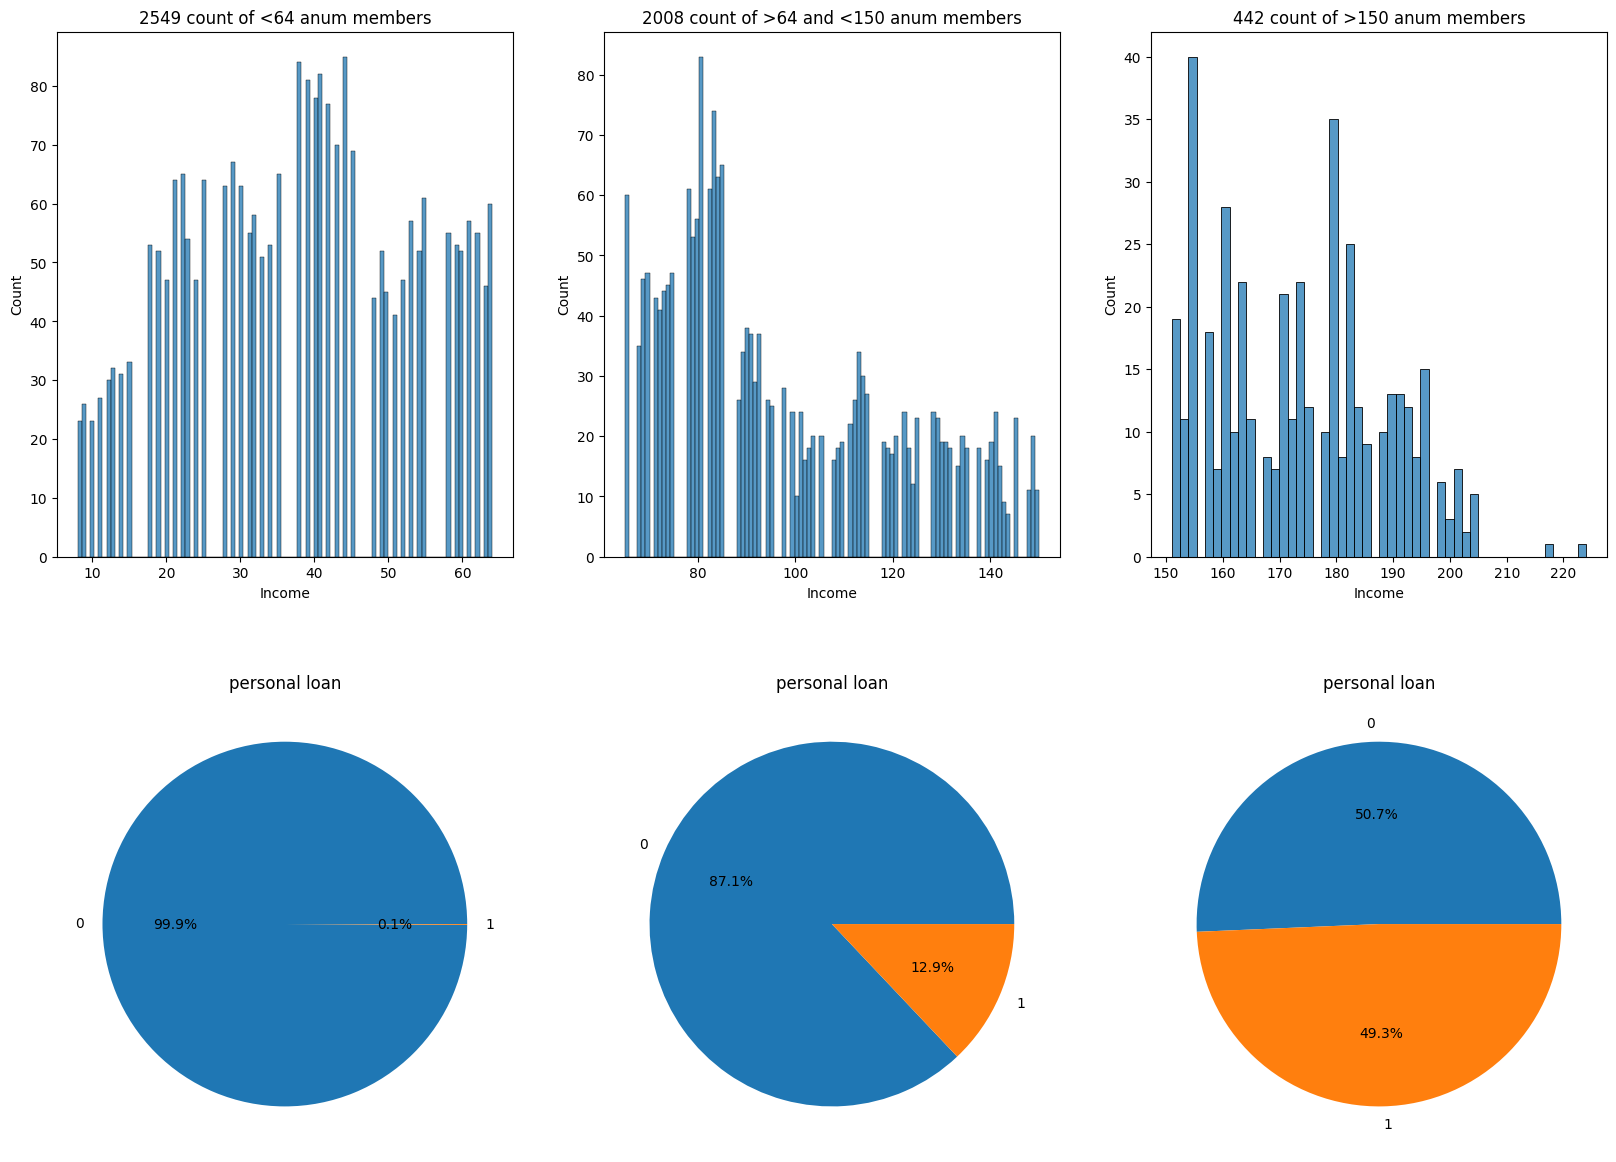

In [ ]:
import seaborn as sb
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 15))


below_50perc = df[df['Income']<=64]
sb.histplot(below_50perc["Income"],ax=axes[0,0],bins=100)
axes[0,0].title.set_text(f'{below_50perc["Income"].shape[0]} count of <64 anum members')
axes[1,0].pie(below_50perc["Personal Loan"].value_counts(),labels=below_50perc["Personal Loan"].value_counts().index,autopct="%1.1f%%")
axes[1,0].title.set_text('personal loan')

above_50perc_below150 = df[(df['Income']>64)&(df['Income']<=150)]
sb.histplot(above_50perc_below150['Income'],ax=axes[0,1],bins=100)
axes[0,1].title.set_text(f'{above_50perc_below150["Income"].shape[0]} count of >64 and <150 anum members')
axes[1,1].pie(above_50perc_below150["Personal Loan"].value_counts(),labels=above_50perc_below150["Personal Loan"].value_counts().index,autopct="%1.1f%%")
axes[1,1].title.set_text('personal loan')

sb.histplot(df.loc[df['Income']>150,'Income'],ax=axes[0,2],bins=50)
axes[0,2].title.set_text(f'{df.loc[df["Income"]>150,"Income"].shape[0]} count of >150 anum members')
axes[1,2].pie(df.loc[df["Income"]>150,"Personal Loan"].value_counts(),labels=df.loc[df["Income"]>150,"Personal Loan"].value_counts().index,autopct="%1.1f%%")
axes[1,2].title.set_text('personal loan')

In [ ]:
# as we can see there is a clear segregation of lower middle class below 64 per anum , middle class between 64 to 150 , upper middle class above 150

# and in them you can see clear difference where the personal loan will be excepted in this data we can do both way erither from the bank side that which customer to offer a personal loan so the effort should not go wasted or from customer side custome can know before applying it that it will clear or not

# personal loan exeptance is propotional to anual income

 75.56 % peoples are below 100$ anual income with average age of 45.64 years


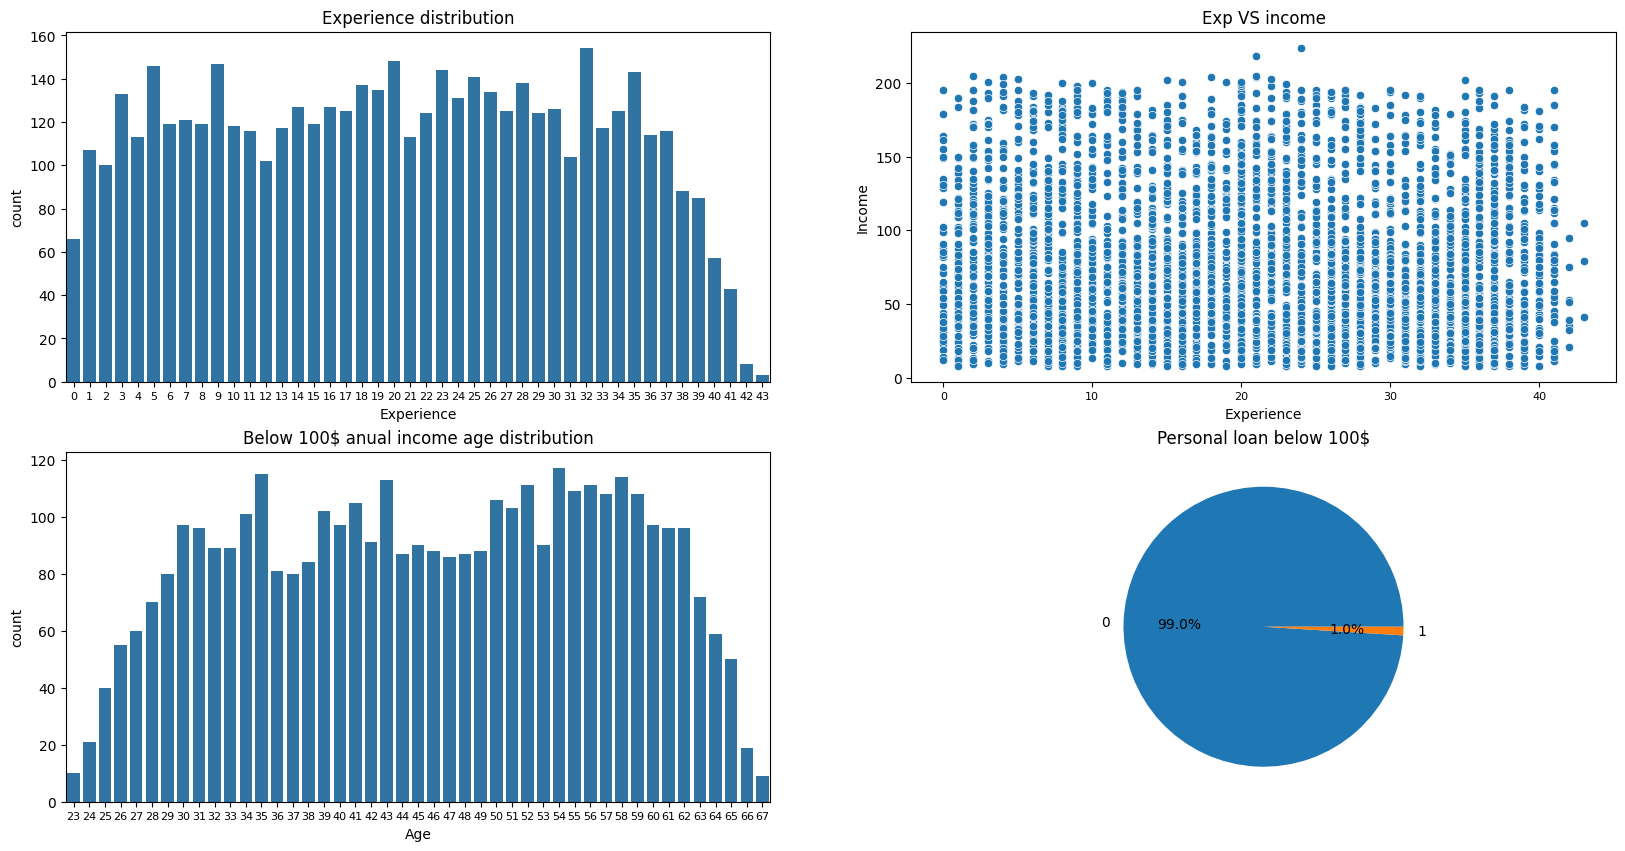

In [ ]:
fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(20,10))
sb.barplot(df.Experience.value_counts(),ax=axes[0,0])
axes[0,0].title.set_text('Experience distribution')
for i in axes:
    for ax in i:
        ax.tick_params(axis='x',labelsize='8')

sb.scatterplot(data=df,x='Experience',y='Income',ax=axes[0,1])
axes[0,1].title.set_text('Exp VS income')

below_100inc = df[df['Income']<100]
print("\033[1m",round(below_100inc.shape[0]*100/df.shape[0],2),"% peoples are below 100$ anual income with average age of",round(below_100inc['Age'].mean(),2),"years\033[0m")
sb.barplot(below_100inc.Age.value_counts(),ax=axes[1,0])
axes[1,0].title.set_text('Below 100$ anual income age distribution')

above_100inc = df[df['Income']<100]
axes[1,1].pie(above_100inc.loc[(above_100inc["Age"]>=30)&(above_100inc["Age"]<=60),"Personal Loan"].value_counts(),labels=above_100inc.loc[(above_100inc["Age"]>=30)&(above_100inc["Age"]<=60),"Personal Loan"].value_counts().index,autopct="%1.1f%%")
axes[1,1].title.set_text('Personal loan below 100$')

In [ ]:
# df.ID.duplicated().sum()
# df = df.reindex(df['ID'])
# df.drop(columns='ID',inplace=True)
df.isna().sum()
df = df.dropna()


In [ ]:
df.columns

Index(['Age', 'Experience', 'Income', 'ZIP Code', 'Family', 'CCAvg',
       'Education', 'Mortgage', 'Personal Loan', 'Securities Account',
       'CD Account', 'Online', 'CreditCard'],
      dtype='object')

# Making model pipeline

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier


scale_cols = ['Income', 'CCAvg', 'Mortgage']

X = df.drop(columns='Personal Loan')
y = df['Personal Loan']

# The rest of the columns (left untouched)
pass_through_cols = [col for col in X.columns if col not in scale_cols]

# Preprocessing transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), scale_cols),
        ('passthrough', 'passthrough', pass_through_cols)
    ]
)

# Full pipeline: Preprocessing + Model
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', XGBClassifier(random_state=42))
])

In [ ]:
stdsc = StandardScaler()

model_df = df.dropna()

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=4)

In [ ]:

pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('scale', StandardScaler(),
                                                  ['Income', 'CCAvg',
                                                   'Mortgage']),
                                                 ('passthrough', 'passthrough',
                                                  ['Age', 'Experience',
                                                   'ZIP Code', 'Family',
                                                   'Education',
                                                   'Securities Account',
                                                   'CD Account', 'Online',
                                                   'CreditCard'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

# Evaluation

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       915
         1.0       0.95      0.88      0.91        85

    accuracy                           0.99      1000
   macro avg       0.97      0.94      0.95      1000
weighted avg       0.99      0.99      0.99      1000



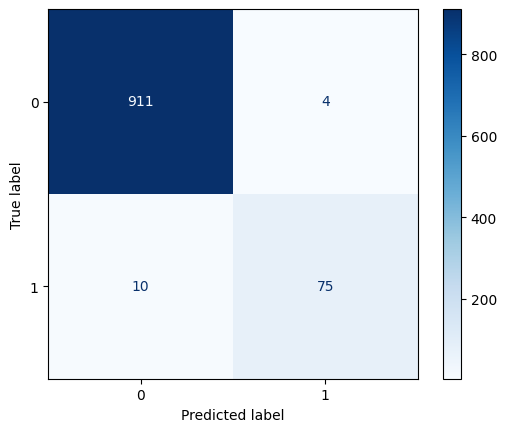

In [ ]:
from sklearn.metrics import f1_score,confusion_matrix,classification_report,ConfusionMatrixDisplay

y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,y_pred))
disp.plot(cmap='Blues',values_format='d')
plt.show()

# SHAP implementation

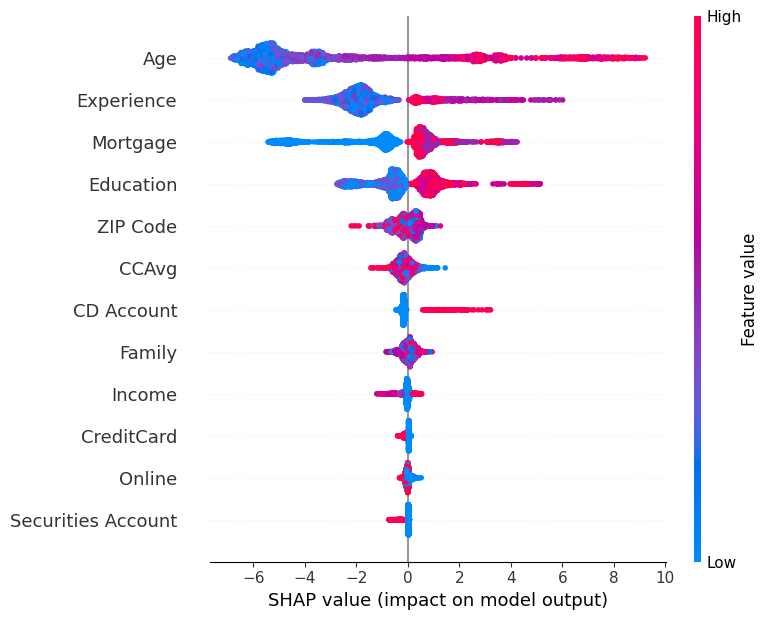

In [ ]:
# Get transformed X_train from pipeline
X_train_transformed = pipeline.named_steps['preprocessing'].transform(X_train)

# Access the XGBoost model
model = pipeline.named_steps['classifier']

explainer = shap.Explainer(model)
shap_values = explainer(X_train_transformed)

shap.summary_plot(shap_values, X_train_transformed, feature_names=X_train.columns)


In [ ]:
sample = X_test.iloc[[0]]
sample_transformed = pipeline.named_steps['preprocessing'].transform(sample)

shap_values_single = explainer(sample_transformed)

shap.plots.force(shap_values_single[0])
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values_single.values, sample_transformed)

joblib.dump(explainer, "shap_explainer.pkl")



['shap_explainer.pkl']

In [ ]:
import joblib
joblib.dump(pipeline,"loan_model_stdsc_xgb_pipeline.pkl")

['loan_model_stdsc_xgb_pipeline.pkl']

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        92
         1.0       1.00      1.00      1.00         8

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



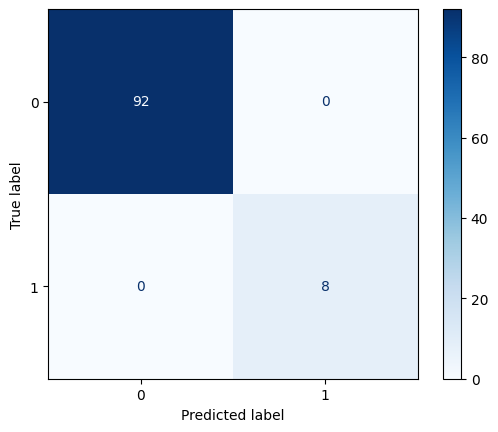

In [ ]:
pipeline_loaded = joblib.load('loan_model_stdsc_xgb_pipeline.pkl')
sampledf = df.sample(100)
prediction = pipeline_loaded.predict(sampledf.drop(columns='Personal Loan'))

y_test = sampledf['Personal Loan']
y_pred = prediction
print(classification_report(y_test, y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,y_pred))
disp.plot(cmap='Blues',values_format='d')
plt.show()